In [22]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [23]:
%reset -f

In [24]:
# importing the requests library 
import requests 
import pandas as pd
import numpy as np
import time
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

from sklearn.model_selection import train_test_split, GridSearchCV

from IPython import display

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout, Conv2D, MaxPooling1D, BatchNormalization, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers import Bidirectional, AveragePooling1D, Flatten, TimeDistributed, Dropout, Reshape, GRU, GlobalAveragePooling2D, Average, Maximum
from keras.layers import Lambda
from keras.optimizers import Adam, Adadelta

from sklearn import metrics
from scipy import stats
from keras.utils import plot_model

tf.test.gpu_device_name()

'/device:GPU:0'

In [25]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12837956845693682856, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9754255845718236757
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8982013590933804423
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14640891840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 759480219662302070
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [26]:
datos = pd.read_csv("/content/drive/My Drive/Curvas de Demandas/CurvasOferta.csv", header=None, index_col=0, verbose=False)
#datos = pd.read_csv("E:\AMAlonso\Alumnos\TFM Zehang Li\SomeCode\CurvasOferta.csv", header=None,index_col=0,verbose=False)

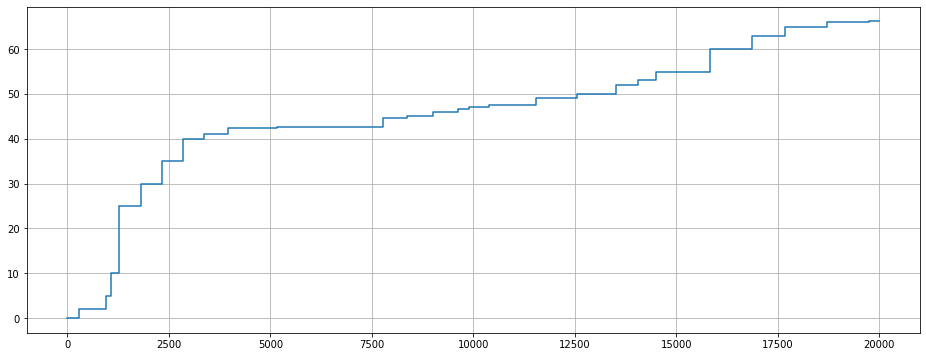

(43824, 500)

In [27]:
q = np.linspace(start = 0, stop = 20000, num=500)
plt.figure(figsize=(16,6))
plt.step(q, datos.iloc[10])
plt.grid()
plt.show()
datos.shape

In [28]:
data_rs = np.reshape(np.array(datos), datos.shape[0]*500)
data_rs.shape

(21912000,)

In [29]:
# Normalizar
#minimo = min(data_rs)
#maximo = max(data_rs)
#data_rs = (data_rs - minimo) / (maximo - minimo)

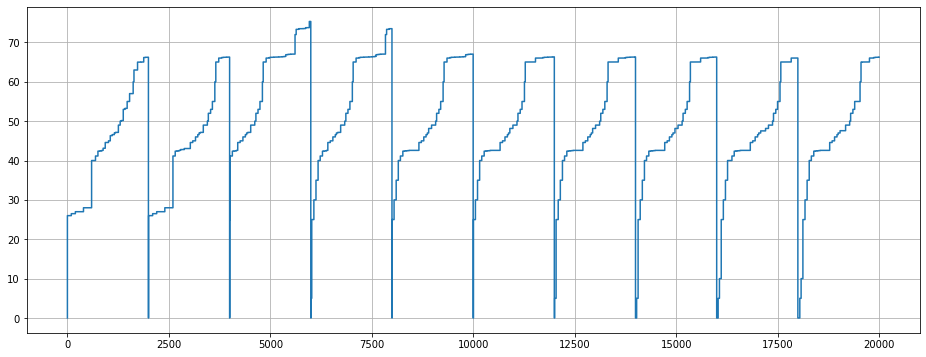

In [30]:
k = 5
plt.figure(figsize=(16,6))
plt.step(np.linspace(start = 0, stop = 2*k*2000, num=2*k*500), data_rs[0:2*k*500])
plt.grid()
plt.show()

In [31]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    range = np.arange(start = 0, stop = len(sequence), step = n_steps_out)
    for i in range:
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        seq_y = sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [32]:
past_hours = 5
forecast_hours = 1
n_steps_in = past_hours*500
n_steps_out = forecast_hours*500
# split into samples
X, y = split_sequence(data_rs, n_steps_in, n_steps_out)
print("Shape X --> " + str(X.shape))
print("Shape y --> " + str(y.shape))

Shape X --> (43819, 2500)
Shape y --> (43819, 500)


In [33]:
test_size = 365*24
train_size = len(X) - test_size
X_train = X[0:train_size]
y_train = y[0:train_size]
X_test = X[train_size:len(X)]
y_test = y[train_size:len(X)]
print("Shape X_train --> " + str(X_train.shape))
print("Shape y_train --> " + str(y_train.shape))
print("Shape X_test  --> " + str(X_test.shape))
print("Shape y_test  --> " + str(y_test.shape))

Shape X_train --> (35059, 2500)
Shape y_train --> (35059, 500)
Shape X_test  --> (8760, 2500)
Shape y_test  --> (8760, 500)


In [34]:
# Baseline Model 
y_pred_baseline = X_test[:,-500*forecast_hours:]
print("Shape X_test  ----------> " + str(X_test.shape))
print("Shape y_pred_baseline --> " + str(y_pred_baseline.shape))
sum(sum(X_test[:,-500*forecast_hours:] != y_pred_baseline)) # Revisar que esta bien la asignacion

Shape X_test  ----------> (8760, 2500)
Shape y_pred_baseline --> (8760, 500)


0

In [35]:
X_train = X_train.reshape((X_train.shape[0], past_hours, X_train.shape[1]//past_hours,1))
X_test = X_test.reshape((X_test.shape[0],  past_hours, X_test.shape[1]//past_hours,1))

In [36]:
print("Shape X_train --> " + str(X_train.shape))
print("Shape X_test  --> " + str(X_test.shape))
print("Shape y_train --> " + str(y_train.shape))
print("Shape y_test  --> " + str(y_test.shape))

Shape X_train --> (35059, 5, 500, 1)
Shape X_test  --> (8760, 5, 500, 1)
Shape y_train --> (35059, 500)
Shape y_test  --> (8760, 500)


In [37]:
from keras import backend as K 

def euc_dist_keras(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))

def max_distance(y_true, y_pred):
    return K.max(K.abs(y_true - y_pred), axis=-1, keepdims=True)

In [38]:
model = Sequential()
model.add(Conv2D(filters = 8, kernel_size = [past_hours, 2], activation = 'relu', padding="same",
                 input_shape=(X_train.shape[1], X_train.shape[2],X_train.shape[3])))
model.add(AveragePooling2D(pool_size= (past_hours, 2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(10))
model.add(Dropout(0.3))
model.add(Dense(n_steps_out, activation='relu'))
model.add(Lambda(lambda x: tf.sort(x)))

model.compile(loss = 'mae', metrics = [max_distance], optimizer = Adam(0.0001))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 5, 500, 8)         88        
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 250, 8)         0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 2000)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                80440     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               5500      
_________________________________________________________________
lambda_1 (Lambda)            (None, None)             

In [39]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=5, verbose=1, factor=0.5, min_lr=2.5e-5)
checkpoint = keras.callbacks.ModelCheckpoint('modelo_prueba{epoch:08d}.h5', save_freq = 5) 

In [ ]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 2, verbose = 1,
                    callbacks=[learning_rate_reduction, early_stopping, checkpoint],
                    validation_data= (X_test, y_test))

Epoch 1/100
17530/17530 [==============================] - 168s 10ms/step - loss: 8.1988 - max_distance: 17.0542 - val_loss: 5.0853 - val_max_distance: 21.9491
Epoch 2/100
17530/17530 [==============================] - 164s 9ms/step - loss: 8.1551 - max_distance: 17.0106 - val_loss: 4.8427 - val_max_distance: 21.7776
Epoch 3/100
17530/17530 [==============================] - 161s 9ms/step - loss: 8.2527 - max_distance: 17.0767 - val_loss: 7.0841 - val_max_distance: 22.7263
Epoch 4/100
17530/17530 [==============================] - 159s 9ms/step - loss: 8.1678 - max_distance: 17.0204 - val_loss: 4.5217 - val_max_distance: 21.5603
Epoch 5/100
17530/17530 [==============================] - 160s 9ms/step - loss: 8.1894 - max_distance: 17.0501 - val_loss: 5.3012 - val_max_distance: 22.0248
Epoch 6/100
17530/17530 [==============================] - 159s 9ms/step - loss: 8.0979 - max_distance: 16.9423 - val_loss: 7.0887 - val_max_distance: 22.6913
Epoch 7/100
17530/17530 [====================

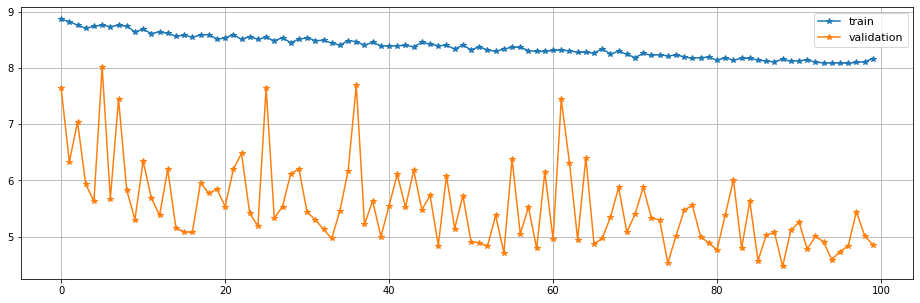

In [45]:
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train', marker='*')
plt.plot(history.history['val_loss'], label='validation', marker='*')
plt.grid()
plt.legend(fontsize=11)

In [30]:
y_pred_redes = model.predict(X_test, verbose=1)

274/274 [==============================] - 1s 2ms/step


In [31]:
#y_test_original = y_test * (maximo - minimo) + minimo
#y_pred_redes_ok = y_pred_redes * (maximo - minimo) + minimo
#y_pred_baseline_ok = y_pred_baseline * (maximo - minimo) + minimo

y_test_original = y_test 
y_pred_redes_ok = y_pred_redes 
y_pred_baseline_ok = y_pred_baseline 

In [32]:
errores_redes = np.empty([len(y_test_original)])
errores_baseline = np.empty([len(y_test_original)])
for i in range(0,len(y_test_original)):
    errores_redes[i] = np.linalg.norm(y_test_original[i] - y_pred_redes_ok[i], np.inf)
    errores_baseline[i] = np.linalg.norm(y_test_original[i] - y_pred_baseline_ok[i], np.inf)

In [33]:
print("Errores usando Redes")
print(pd.DataFrame(errores_redes).describe().transpose().round(2))
print("Errores usando Baseline")
print(pd.DataFrame(errores_baseline).describe().transpose().round(2))

Errores usando Redes
    count   mean     std   min   25%    50%    75%      max
0  8760.0  20.14  106.79  2.37  9.29  12.58  27.23  9918.01
Errores usando Baseline
    count   mean     std   min  25%   50%    75%     max
0  8760.0  21.36  150.68  0.42  4.7  8.99  33.59  9913.7


In [34]:
s1 = errores_baseline[errores_baseline < np.percentile(errores_baseline, 95)]
s2 = errores_redes[errores_redes < np.percentile(errores_redes, 95)]

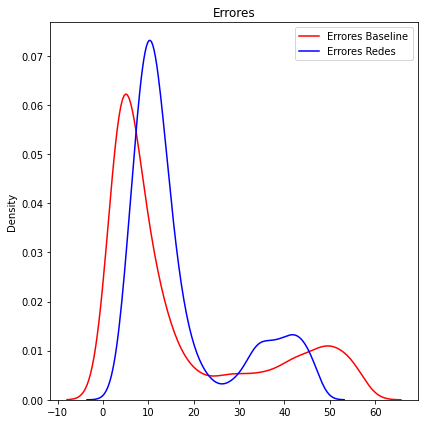

In [35]:
plt.figure(figsize=(6,6))
sns.kdeplot(s1, color = "red",  label = 'Errores Baseline')
sns.kdeplot(s2, color = "blue", label = 'Errores Redes')
plt.title('Errores')
plt.tight_layout()
plt.legend()
plt.show()

In [36]:
best_baseline = np.argmin(errores_baseline)
worse_baseline = np.argmax(errores_baseline)
print("Posicion mejor Baseline Model: " + str(best_baseline))
print("Posicion peor Baseline Model: " + str(worse_baseline))

best_redes = np.argmin(errores_redes)
worse_redes = np.argmax(errores_redes)
print("Posicion mejor Redes Model: " + str(best_redes))
print("Posicion peor Redes Model: " + str(worse_redes))

Posicion mejor Baseline Model: 1334
Posicion peor Baseline Model: 4774
Posicion mejor Redes Model: 533
Posicion peor Redes Model: 4774


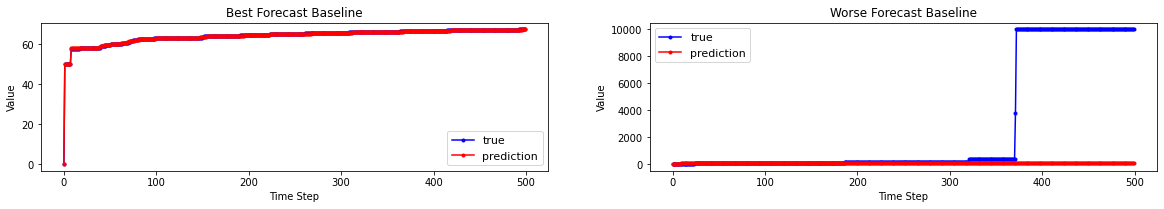

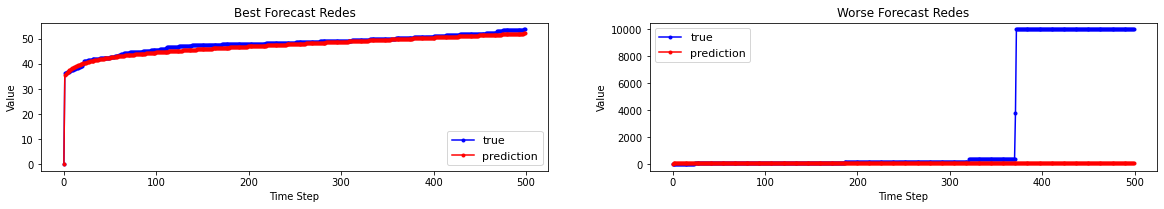

In [ ]:
plt.figure(figsize=(20, 6))
plt.subplot(221)
plt.title("Best Forecast Baseline")
plt.plot(y_test[best_baseline], color = "blue", marker='.', label="true")
plt.plot(y_pred_baseline[best_baseline], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.subplot(222)
plt.title("Worse Forecast Baseline")
plt.plot(y_test[worse_baseline], color = "blue", marker='.', label="true")
plt.plot(y_pred_baseline[worse_baseline], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.figure(figsize=(20, 6))
plt.subplot(223)
plt.title("Best Forecast Redes")
plt.plot(y_test[best_redes],  color = "blue", marker='.', label="true")
plt.plot(y_pred_redes[best_redes], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.subplot(224)
plt.title("Worse Forecast Redes")
plt.plot(y_test[worse_redes], color = "blue", marker='.', label="true")
plt.plot(y_pred_redes[worse_redes], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11) 
plt.show();

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/Curvas de Demandas/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/Curvas de Demandas/model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from keras.models import model_from_json
# load json and create model
json_file = open('/content/drive/My Drive/Curvas de Demandas/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/Curvas de Demandas/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
from keras import backend as K 

def euc_dist_keras(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))

def max_distance(y_true, y_pred):
    return K.max(K.abs(y_true - y_pred), axis=-1, keepdims=True)

In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss = 'mae', metrics = [max_distance], optimizer = Adam(0.001))

loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 4, 500, 8)         72        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 250, 8)         0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 2000)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                80440     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               5500      
_________________________________________________________________
lambda_2 (Lambda)            (None, None)             

In [ ]:
y_pred = loaded_model.predict(X_test, verbose=1)

In [ ]:
errores_redes = np.empty([len(y_test_original)])
for i in range(0,len(y_test_original)):
    errores_redes[i] = np.linalg.norm(y_test_original[i] - y_pred[i], np.inf)

print("Errores usando Redes")
print(pd.DataFrame(errores_redes).describe().transpose().round(2))

Errores usando Redes
    count   mean     std   min    25%    50%    75%      max
0  8760.0  26.41  106.56  3.25  17.62  25.52  33.83  9941.12
